[9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.

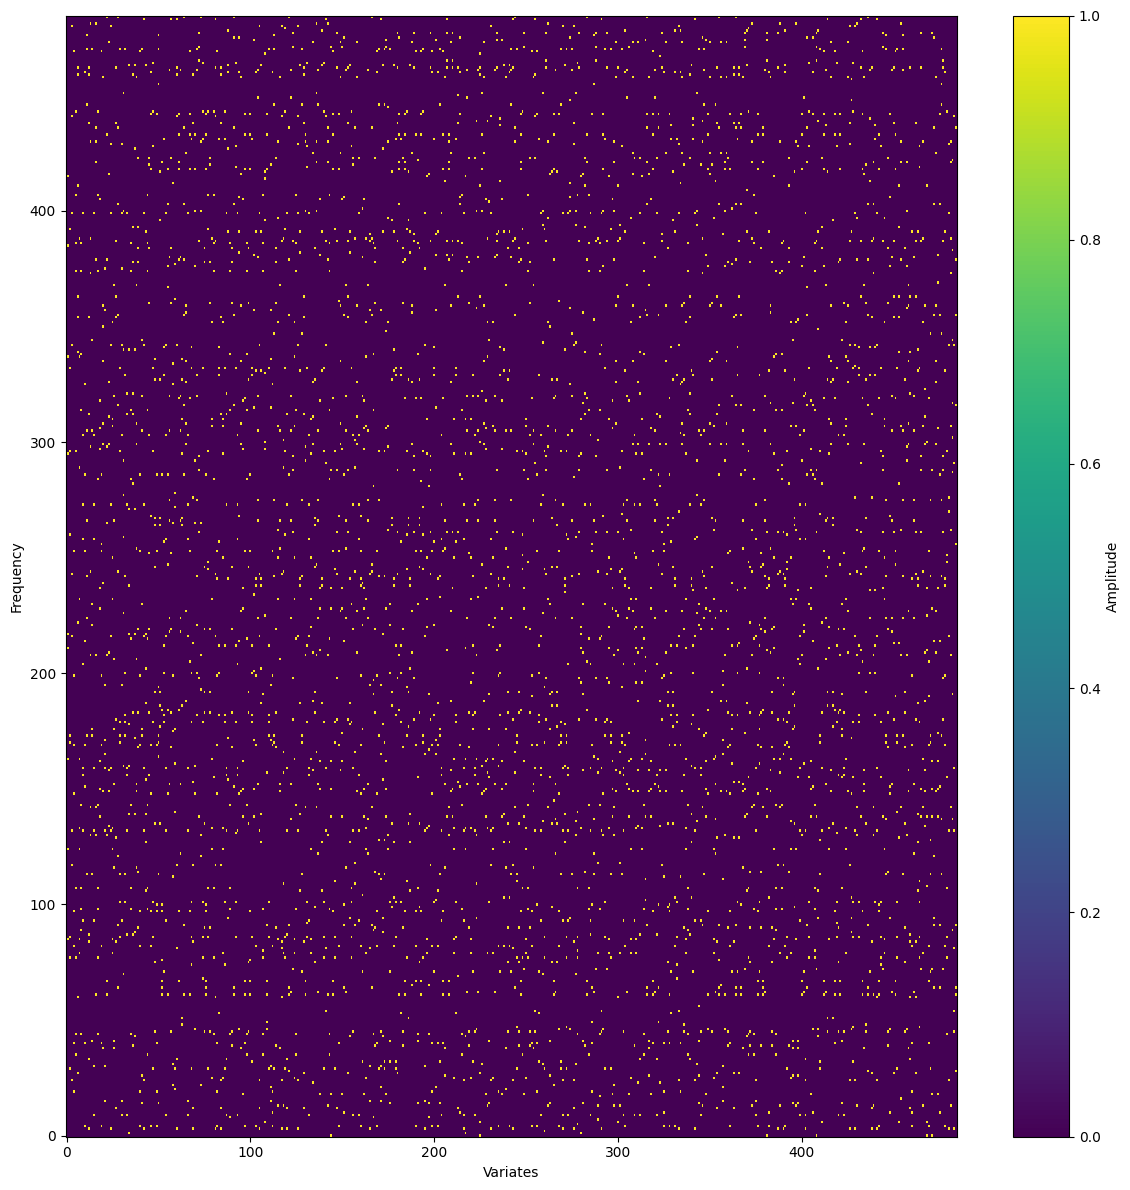

In [11]:

from basicts.visualize_dataset import window_similarity_visualize, timeseries_visualize, \
    st_indistinguishability_visualize
from utils.visualize import plot_mesh
import numpy as np

# note
# 这一个cell的目的，
# note 参数区
# 数据集的位置
result_data_graph = "../datasets/CER-E/adj_correlation.pkl"

def calculate_normalized_laplacian_matrix(adj):
    """
    计算一个邻接矩阵的标准化拉普拉斯矩阵
    note 邻接矩阵要求没有自己到自己的边
    """
    # note 先计算度矩阵和标准化后的度矩阵
    # adj += np.eye(adj.shape[0])
    degree = np.sum(adj, axis=-1)
    print(np.max(degree), np.min(degree))
    degree_mat = np.diag(degree)
    normalized_degree = 1 / np.sqrt(degree)
    normalized_degree_mat = np.diag(normalized_degree)
    # note 再计算拉普拉斯矩阵
    laplacian = degree_mat - adj
    return np.matmul(np.matmul(normalized_degree_mat, laplacian), normalized_degree_mat)

def visualize_predefine_graph(npz_path: str):
    # note 加载数据，确保对角线一定是1
    adj = np.load(npz_path, allow_pickle=True)
    print(np.sum(adj, axis=-1))
    print(np.mean(np.sum(adj, axis=-1)), np.std(np.sum(adj, axis=-1)))
    # note 再进行图的绘制
    plot_mesh(title=f"predefined graph of {npz_path}",
              amplitude=adj,
              save_fig=False)
    # note 再尝试得到每一个节点走3跳得到的地方

visualize_predefine_graph(result_data_graph)

In [19]:

import numpy as np
# 预测值的位置
# GWN的
result_file_dir = "../checkpoints/GraphWaveNet/PEMS04_100_12_12/2685972f0c44e3dab84cd76ce891c2d2/test_results.npz"

def fourier_basis_np(ts: np.ndarray):
    """
    进行傅里叶基扩展
    :param ts: (any shape, T): 任何形状，最后一个维度是时间序列
    :return result: (any shape, components, T)
    """
    # note 基础设置
    time_steps = ts.shape[-1]
    components = time_steps // 2 + 1

    # 扩放指数
    scale = np.ones(components)
    if time_steps % 2 == 0:
        scale[1:-1] = 2.0  # 偶数长度时，中间分量缩放2倍
    else:
        scale[1:] = 2.0     # 奇数长度时，所有非零分量缩放2倍
    scale /= 12.0

    steps = np.arange(time_steps, dtype=np.float32)
    sin_np = [np.sin(steps*2*np.pi*k/time_steps) for k in range(components)]
    # (components, T)
    sin_np = np.stack(sin_np, axis=0)
    cos_np = [np.cos(steps*2*np.pi*k/time_steps) for k in range(components)]
    # (components, T)
    cos_np = np.stack(cos_np, axis=0)
    # note 分别进行实部和虚部的展开
    # (any shape, components)
    fourier_repr_ts = np.fft.rfft(ts, axis=-1)
    real_ts, image_ts = np.expand_dims(fourier_repr_ts.real * scale, axis=-1), np.expand_dims(fourier_repr_ts.imag * scale, axis=-1)
    fourier_ts = np.einsum("...ci,cT->...cT", real_ts, cos_np) - np.einsum("...ci,cT->...cT", image_ts, sin_np)
    return fourier_ts

def visualize_fourier(rfd: str):
    """
    这个函数用来验证傅里叶基扩展的正确性
    """
    # (I, T, N, F)
    inputs, target, prediction = read_result_file(rfd)
    fts = fourier_basis_np(inputs[0, :, 0, 0])
    return fts

def visualize_graph():
    """
    这个函数的目的，是：
    1. 可视化原始数据中某个分量的相似性
    2. 可视化预测值中某个分量的相似性
    """
    pass

visualize_fourier(result_file_dir)

[ 87.          55.00000004  48.99998259  44.99998612  93.0000057
  91.9999902   77.99999739  93.0000053   98.99999436  96.0000082
 100.00001457 112.00001161] [ 87.        55.        48.999985  44.999985  93.        92.
  78.        93.        98.99999   96.       100.       112.      ]


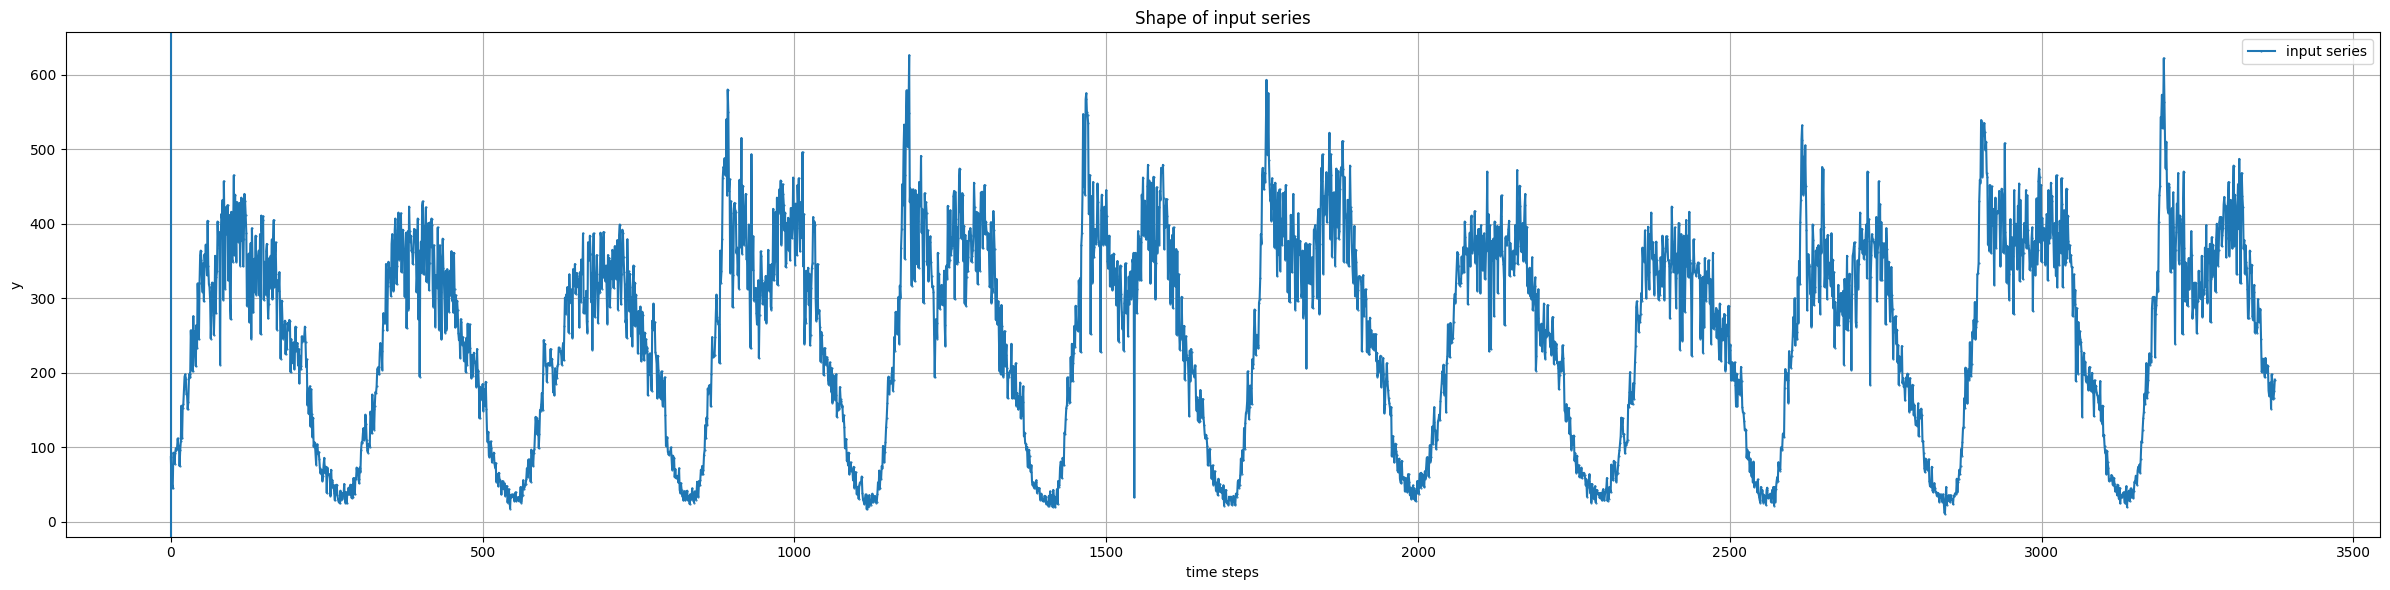

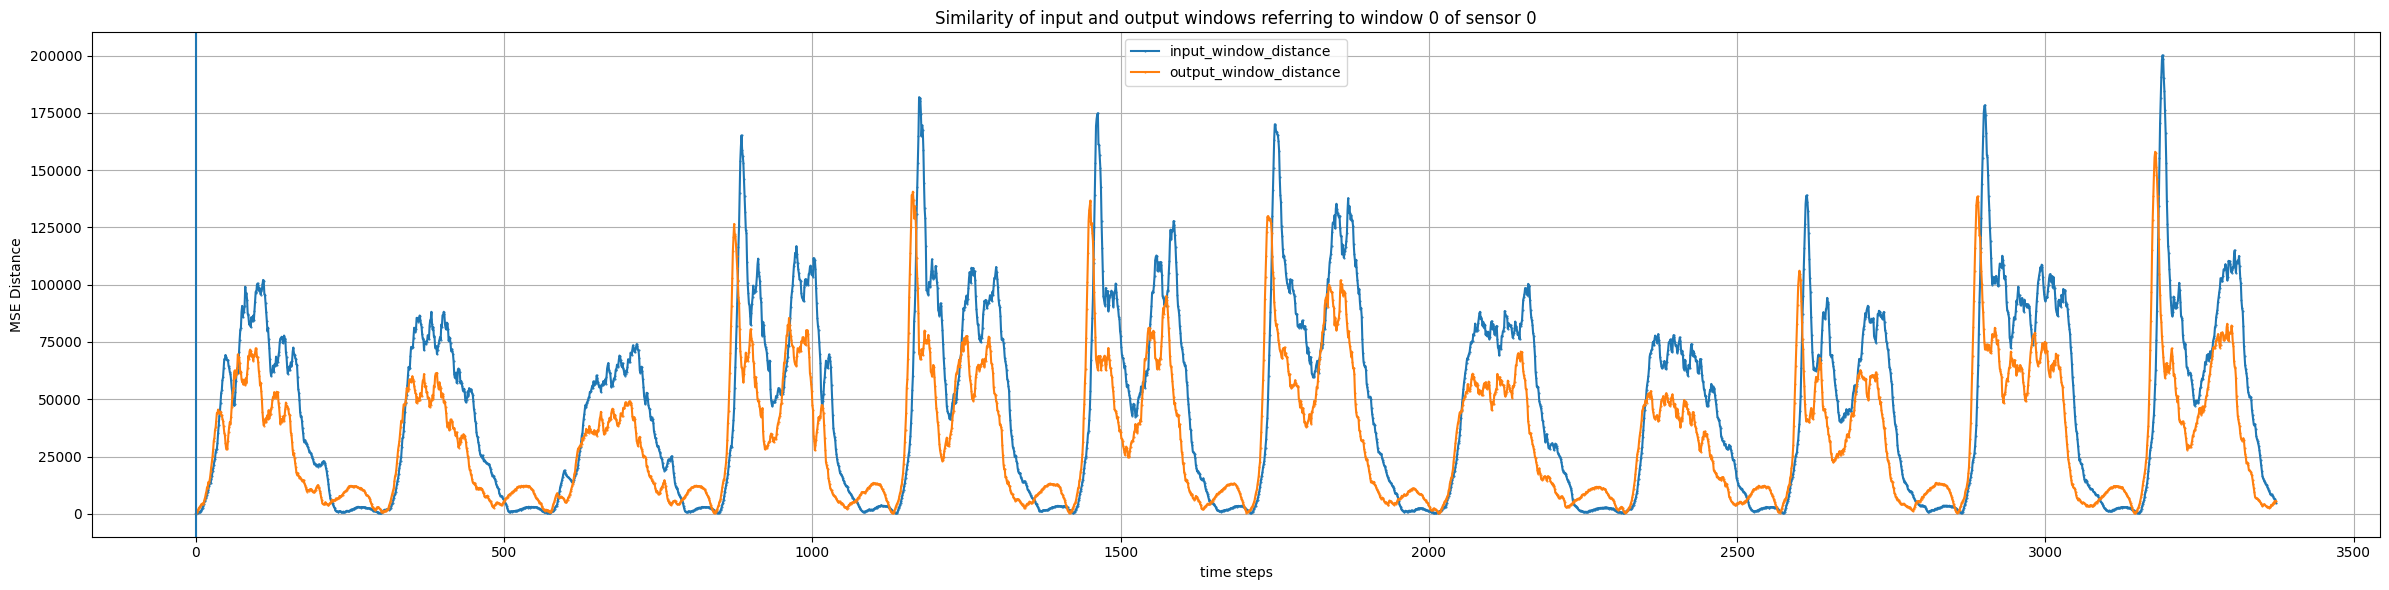

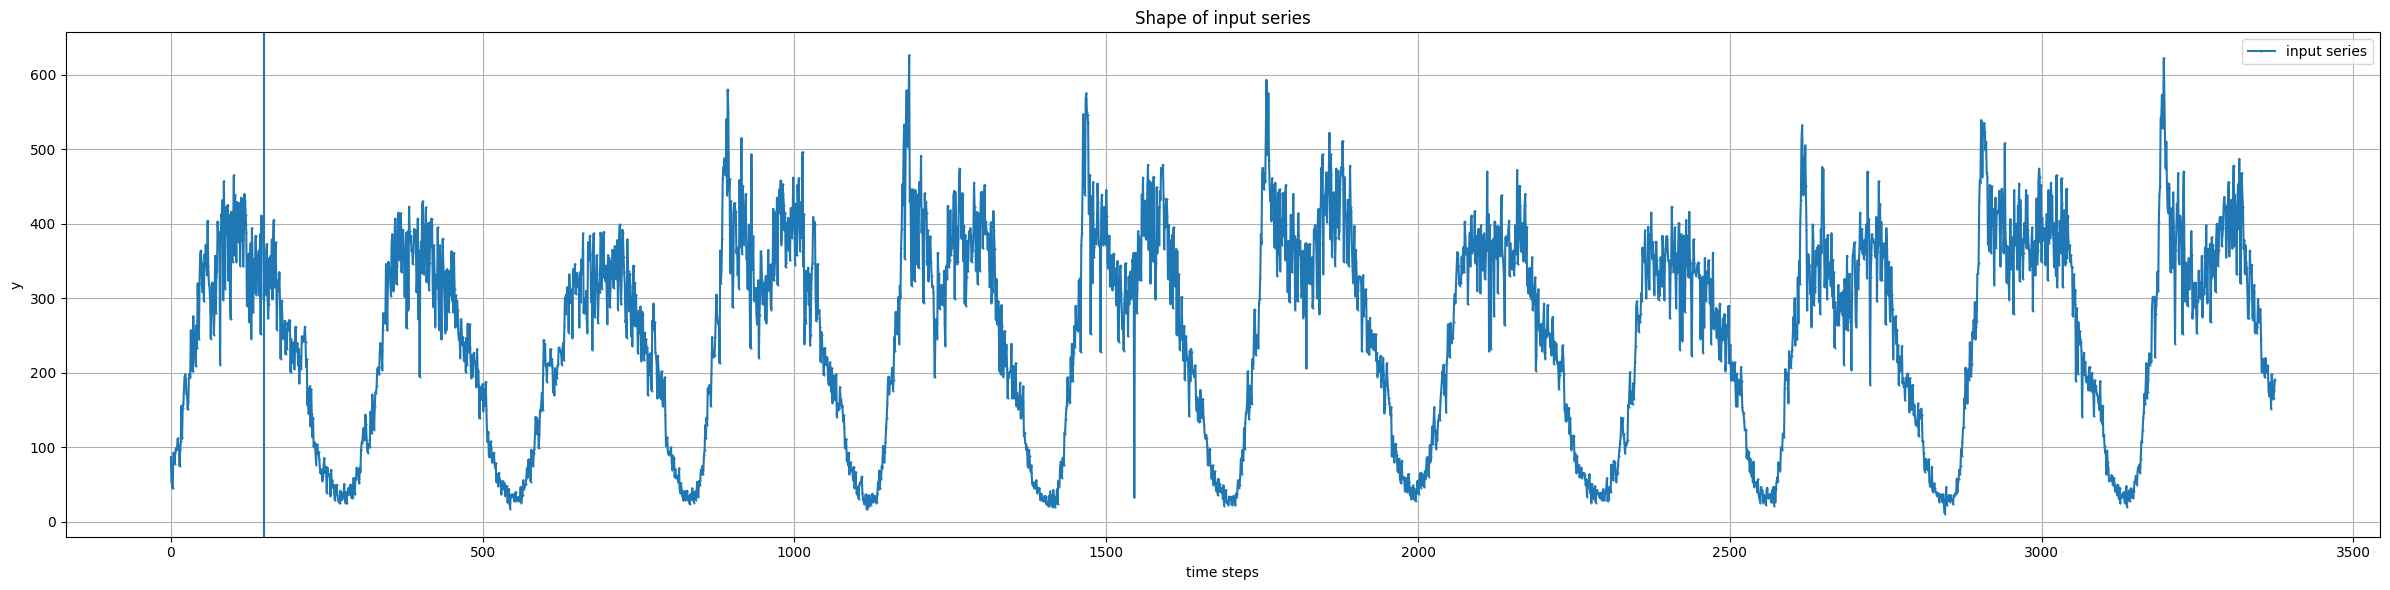

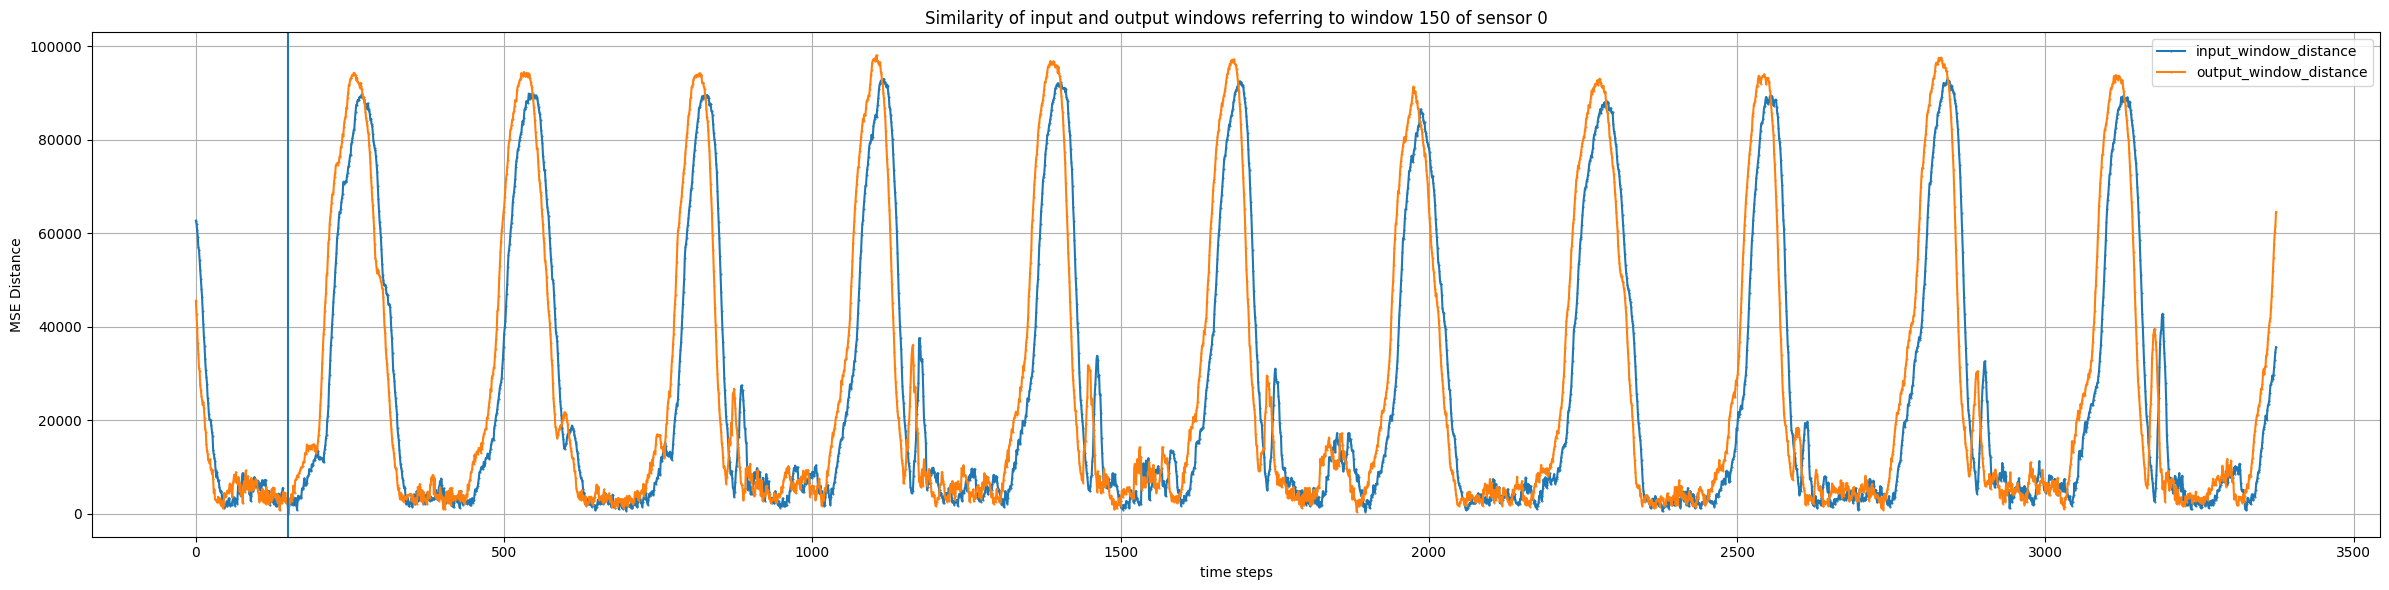

In [8]:
# 这一个cell的意义，是展示不同的输入窗口之间的相似性

from basicts.utils.result import read_result_file
import numpy as np

# 结果文件的地址
result_file_dir = "../checkpoints/GraphWaveNet/PEMS04_100_12_12/2685972f0c44e3dab84cd76ce891c2d2/test_results.npz"

timeseries_visualize(result_file_dir, 0, 0)
window_similarity_visualize(result_file_dir, 0, 0)
timeseries_visualize(result_file_dir, 150, 0)
window_similarity_visualize(result_file_dir, 150, 0)


(3375, 307, 307)
(307, 307)


/data/hanzhi/Projects/BasicTS/basicts/visualize_dataset.py:55: RuntimeWarning: divide by zero encountered in divide
  relative_stid = np.abs((input_mse - target_mse) / input_mse)
/data/hanzhi/Projects/BasicTS/basicts/visualize_dataset.py:55: RuntimeWarning: invalid value encountered in divide
  relative_stid = np.abs((input_mse - target_mse) / input_mse)


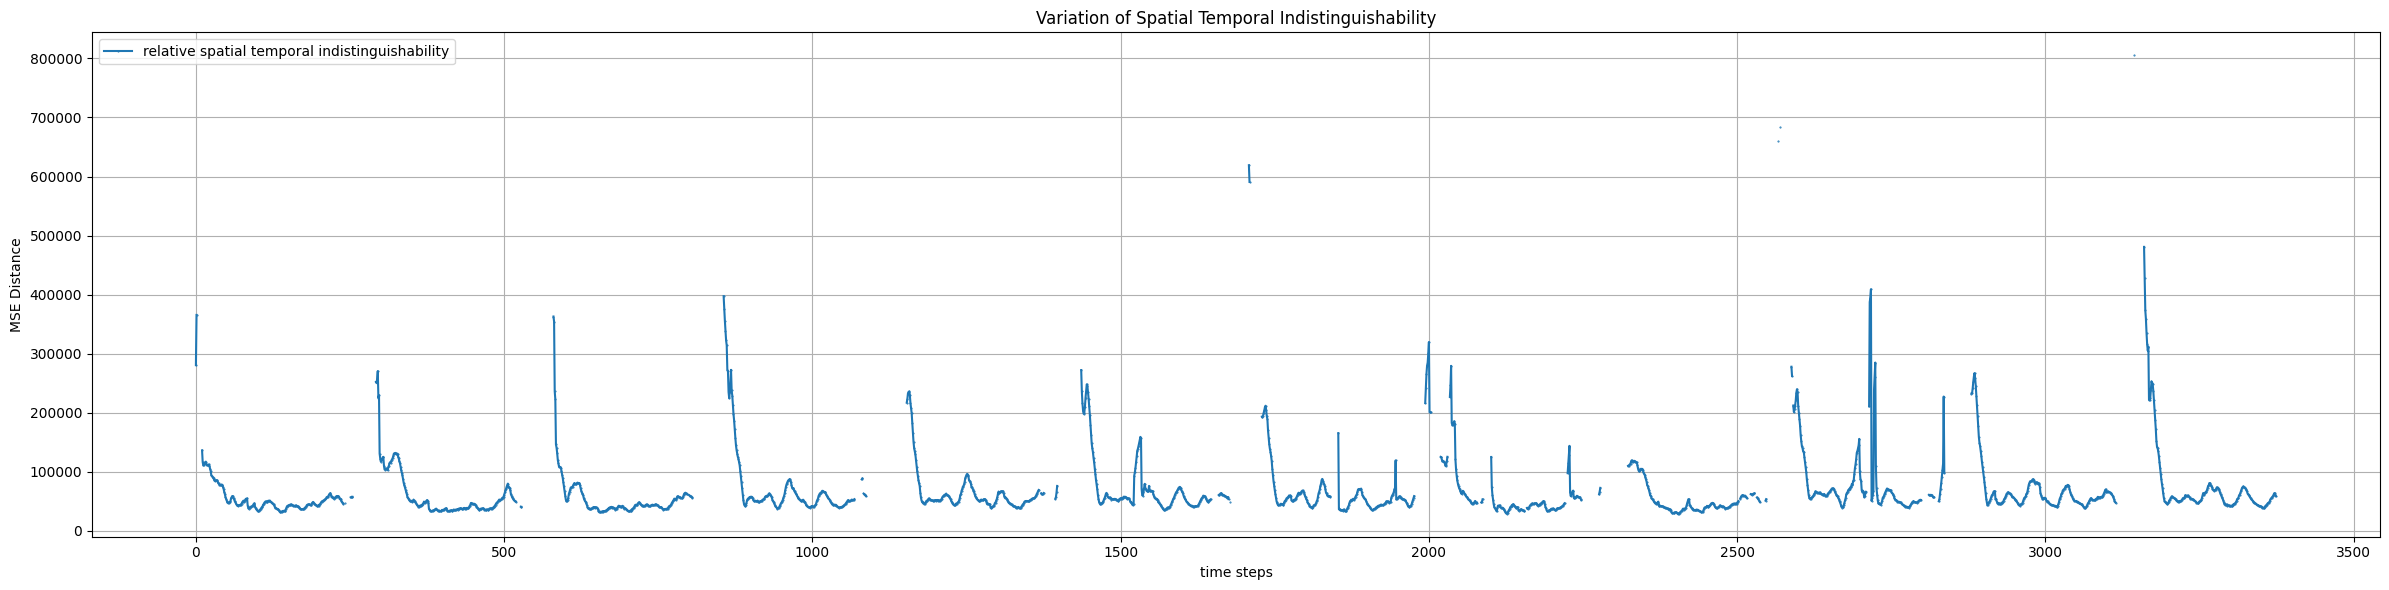

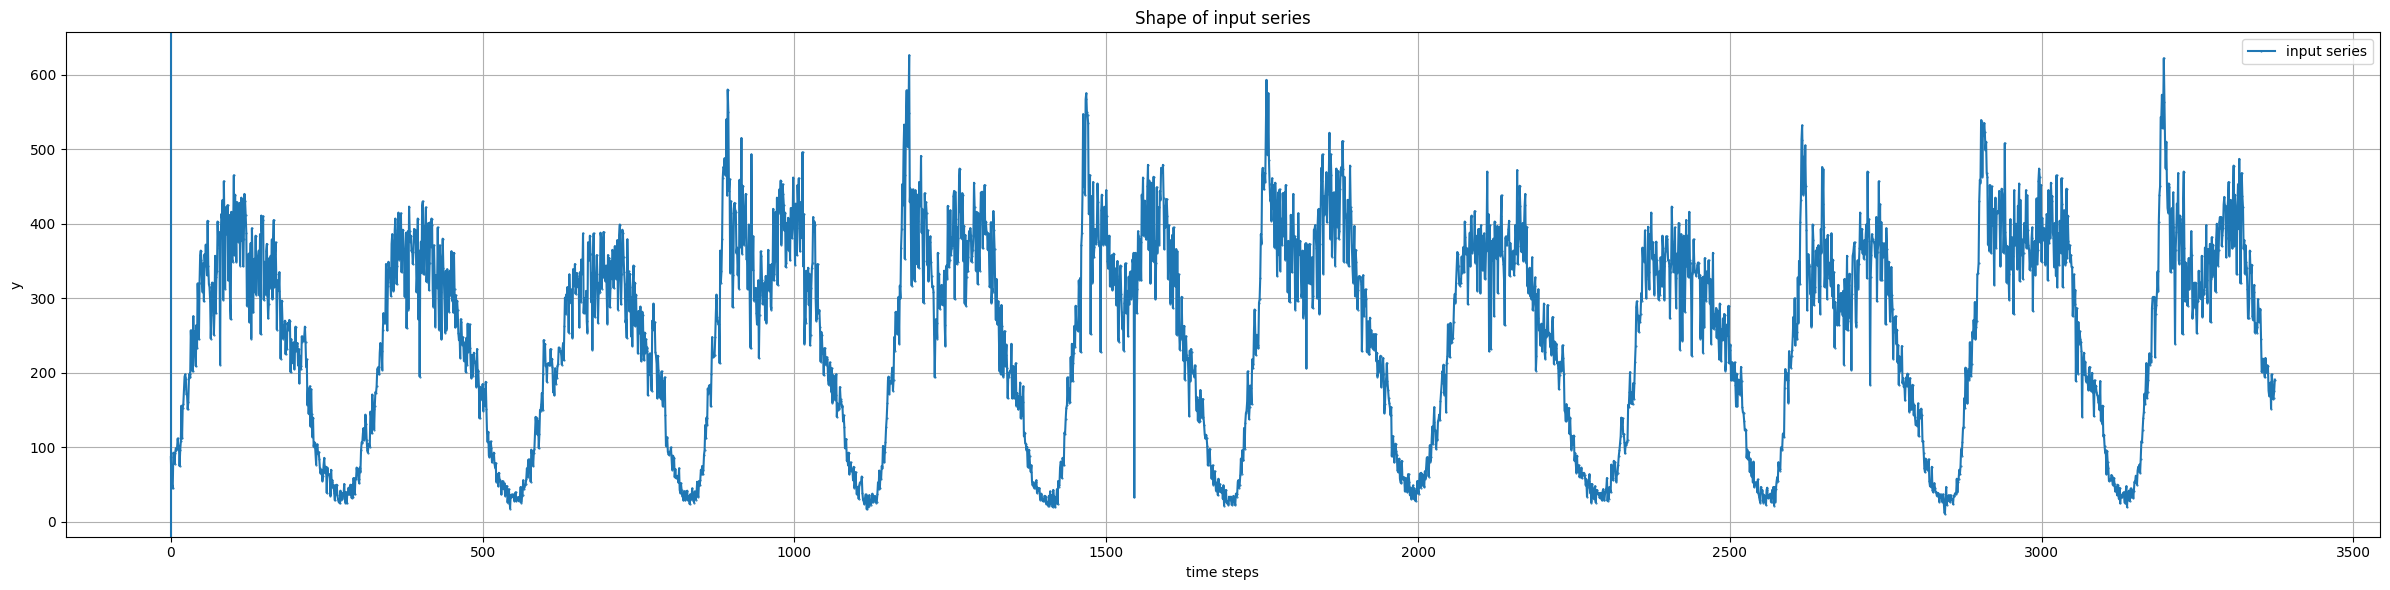

In [2]:
result_file_dir = "../checkpoints/GraphWaveNet/PEMS04_100_12_12/2685972f0c44e3dab84cd76ce891c2d2/test_results.npz"

st_indistinguishability_visualize(result_file_dir)
timeseries_visualize(result_file_dir, 0, 0)
